In [1]:
from google.colab import drive

# cd into directory in GDrive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/NLP/GitHub/C2_Probabilistic_Models/02_Part_of_Speech_Tagging

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/NLP/GitHub/C2_Probabilistic_Models/02_Part_of_Speech_Tagging


# Assignment 2: Parts-of-Speech Tagging (POS)

Welcome to the second assignment of Course 2 in the Natural Language Processing specialization. This assignment will develop skills in part-of-speech (POS) tagging, the process of assigning a part-of-speech tag (Noun, Verb, Adjective...) to each word in an input text.  Tagging is difficult because some words can represent more than one part of speech at different times. They are  **Ambiguous**. Let's look at the following example: 

- The whole team played **well**. [adverb]
- You are doing **well** for yourself. [adjective]
- **Well**, this assignment took me forever to complete. [interjection]
- The **well** is dry. [noun]
- Tears were beginning to **well** in her eyes. [verb]

Distinguishing the parts-of-speech of a word in a sentence will help you better understand the meaning of a sentence. This would be critically important in search queries. Identifying the proper noun, the organization, the stock symbol, or anything similar would greatly improve everything ranging from speech recognition to search. By completing this assignment, you will: 

- Learn how parts-of-speech tagging works
- Compute the transition matrix A in a Hidden Markov Model
- Compute the emission matrix B in a Hidden Markov Model
- Compute the Viterbi algorithm 
- Compute the accuracy of your own model 

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/probabilistic-models-in-nlp/supplement/saGQf/how-to-refresh-your-workspace).

## Table of Contents

- [0 - Data Sources](#0)
- [1 - Parts-of-speech Tagging](#1)
    - [1.1 - Training](#1.1)
        - [Exercise 1 - create_dictionaries (UNQ_C1)](#ex-1)
    - [1.2 - Testing](#1.2)
        - [Exercise 2 - predict_pos (UNQ_C2)](#ex-2)
- [2 - Hidden Markov Models for POS](#2)
    - [2.1 - Generating Matrices](#2.1)
        - [Exercise 3 - create_transition_matrix (UNQ_C3)](#ex-3)
        - [Exercise 4 - create_emission_matrix (UNQ_C4)](#ex-4)
- [3 - Viterbi Algorithm and Dynamic Programming](#3)
    - [3.1 - Initialization](#3.1)
        - [Exercise 5 - initialize (UNQ_C5)](#ex-5)
    - [3.2 - Viterbi Forward](#3.2)
        - [Exercise 6 - viterbi_forward (UNQ_C6)](#ex-6)
    - [3.3 - Viterbi Backward](#3.3)
        - [Exercise 7 - viterbi_backward (UNQ_C7)](#ex-7)
- [4 - Predicting on a Dataset](#4)
    - [Exercise 8 - compute_accuracy (UNQ_C8)](#ex-8)

In [2]:
# Importing packages and loading in the data set 
from utils_pos import get_word_tag, preprocess  
import pandas as pd
from collections import defaultdict
import math
import numpy as np
import w2_unittest

<a name='0'></a>
## 0 - Data Sources
This assignment will use two tagged data sets collected from the **Wall Street Journal (WSJ)**. 

[Here](http://relearn.be/2015/training-common-sense/sources/software/pattern-2.6-critical-fork/docs/html/mbsp-tags.html) is an example 'tag-set' or Part of Speech designation describing the two or three letter tag and their meaning. 
- One data set (**WSJ-2_21.pos**) will be used for **training**.
- The other (**WSJ-24.pos**) for **testing**. 
- The tagged training data has been preprocessed to form a vocabulary (**hmm_vocab.txt**). 
- The words in the vocabulary are words from the training set that were used two or more times. 
- The vocabulary is augmented with a set of 'unknown word tokens', described below. 

The training set will be used to create the emission, transition and tag counts. 

The test set (WSJ-24.pos) is read in to create `y`. 
- This contains both the test text and the true tag. 
- The test set has also been preprocessed to remove the tags to form **test_words.txt**. 
- This is read in and further processed to identify the end of sentences and handle words not in the vocabulary using functions provided in **utils_pos.py**. 
- This forms the list `prep`, the preprocessed text used to test our  POS taggers.

A POS tagger will necessarily encounter words that are not in its datasets. 
- To improve accuracy, these words are further analyzed during preprocessing to extract available hints as to their appropriate tag. 
- For example, the suffix 'ize' is a hint that the word is a verb, as in 'final-ize' or 'character-ize'. 
- A set of unknown-tokens, such as '--unk-verb--' or '--unk-noun--' will replace the unknown words in both the training and test corpus and will appear in the emission, transition and tag data structures.

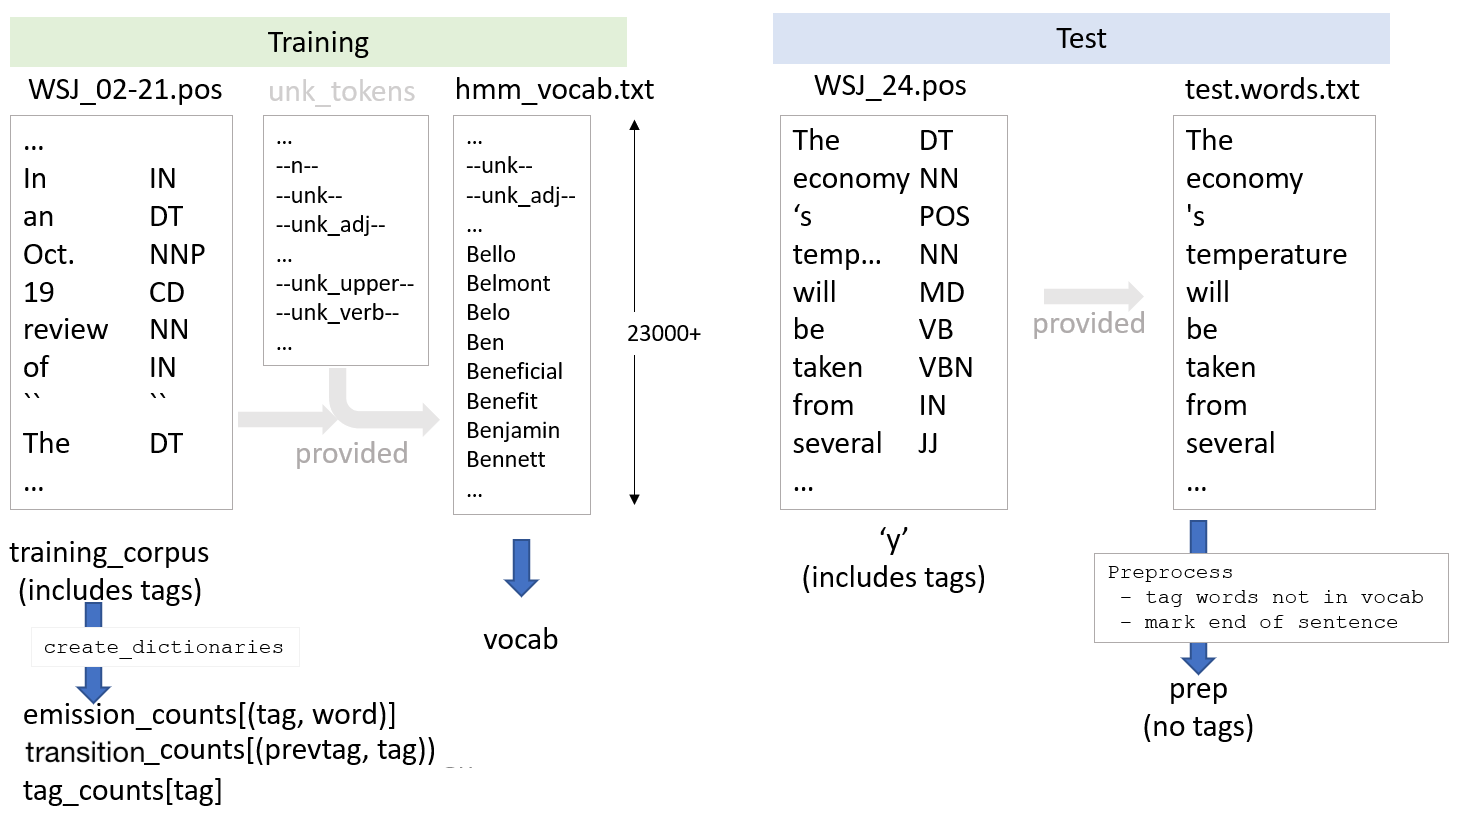

Implementation note: 

- For python 3.6 and beyond, dictionaries retain the insertion order. 
- Furthermore, their hash-based lookup makes them suitable for rapid membership tests. 
    - If _di_ is a dictionary, `key in di` will return `True` if _di_ has a key _key_, else `False`. 

The dictionary `vocab` will utilize these features.

In [3]:
# load in the training corpus
with open("./data/WSJ_02-21.pos", 'r') as f:
    training_corpus = f.readlines()

print(f"A few items of the training corpus list")
print(training_corpus[0:5])

A few items of the training corpus list
['In\tIN\n', 'an\tDT\n', 'Oct.\tNNP\n', '19\tCD\n', 'review\tNN\n']


In [4]:
# read the vocabulary data, split by each line of text, and save the list
with open("./data/hmm_vocab.txt", 'r') as f:
    voc_l = f.read().split('\n')

print("A few items of the vocabulary list")
print(voc_l[0:50])
print()
print("A few items at the end of the vocabulary list")
print(voc_l[-50:])

A few items of the vocabulary list
['!', '#', '$', '%', '&', "'", "''", "'40s", "'60s", "'70s", "'80s", "'86", "'90s", "'N", "'S", "'d", "'em", "'ll", "'m", "'n'", "'re", "'s", "'til", "'ve", '(', ')', ',', '-', '--', '--n--', '--unk--', '--unk_adj--', '--unk_adv--', '--unk_digit--', '--unk_noun--', '--unk_punct--', '--unk_upper--', '--unk_verb--', '.', '...', '0.01', '0.0108', '0.02', '0.03', '0.05', '0.1', '0.10', '0.12', '0.13', '0.15']

A few items at the end of the vocabulary list
['yards', 'yardstick', 'year', 'year-ago', 'year-before', 'year-earlier', 'year-end', 'year-on-year', 'year-round', 'year-to-date', 'year-to-year', 'yearlong', 'yearly', 'years', 'yeast', 'yelled', 'yelling', 'yellow', 'yen', 'yes', 'yesterday', 'yet', 'yield', 'yielded', 'yielding', 'yields', 'you', 'young', 'younger', 'youngest', 'youngsters', 'your', 'yourself', 'youth', 'youthful', 'yuppie', 'yuppies', 'zero', 'zero-coupon', 'zeroing', 'zeros', 'zinc', 'zip', 'zombie', 'zone', 'zones', 'zoning', '{',

In [5]:
# vocab: dictionary that has the index of the corresponding words
vocab = {}

# Get the index of the corresponding words. 
for i, word in enumerate(sorted(voc_l)): 
    vocab[word] = i       
    
print("Vocabulary dictionary, key is the word, value is a unique integer")
cnt = 0
for k,v in vocab.items():
    print(f"{k}:{v}")
    cnt += 1
    if cnt > 20:
        break

Vocabulary dictionary, key is the word, value is a unique integer
:0
!:1
#:2
$:3
%:4
&:5
':6
'':7
'40s:8
'60s:9
'70s:10
'80s:11
'86:12
'90s:13
'N:14
'S:15
'd:16
'em:17
'll:18
'm:19
'n':20


In [6]:
# load in the test corpus
with open("./data/WSJ_24.pos", 'r') as f:
    y = f.readlines()
    
print("A sample of the test corpus")
print(y[0:10])

A sample of the test corpus
['The\tDT\n', 'economy\tNN\n', "'s\tPOS\n", 'temperature\tNN\n', 'will\tMD\n', 'be\tVB\n', 'taken\tVBN\n', 'from\tIN\n', 'several\tJJ\n', 'vantage\tNN\n']


In [7]:
#corpus without tags, preprocessed
_, prep = preprocess(vocab, "./data/test.words")     

print('The length of the preprocessed test corpus: ', len(prep))
print('This is a sample of the test_corpus: ')
print(prep[0:10])

The length of the preprocessed test corpus:  34199
This is a sample of the test_corpus: 
['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']


<a name='1'></a>
## 1 - Parts-of-speech Tagging 

<a name='1.1'></a>
### 1.1 - Training
You will start with the simplest possible parts-of-speech tagger and we will build up to the state of the art. 

In this section, you will find the words that are not ambiguous. 
- For example, the word `is` is a verb and it is not ambiguous. 
- In the `WSJ` corpus, $86$% of the token are unambiguous (meaning they have only one tag) 
- About $14\%$ are ambiguous (meaning that they have more than one tag)

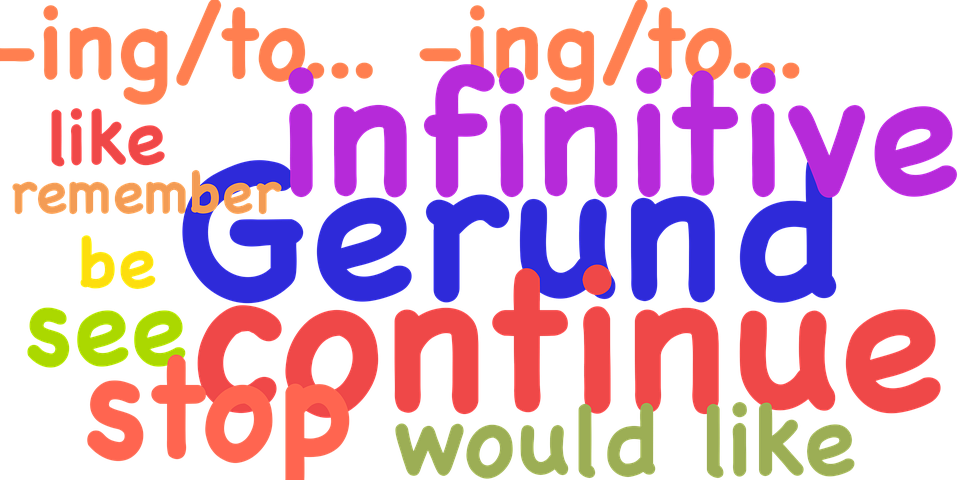

Before you start predicting the tags of each word, you will need to compute a few dictionaries that will help you to generate the tables. 

#### Transition counts
- The first dictionary is the `transition_counts` dictionary which computes the number of times each tag happened next to another tag. 

This dictionary will be used to compute: 
$$P(t_i |t_{i-1}) \tag{1}$$

This is the probability of a tag at position $i$ given the tag at position $i-1$.

In order for you to compute equation 1, you will create a `transition_counts` dictionary where 
- The keys are `(prev_tag, tag)`
- The values are the number of times those two tags appeared in that order. 

#### Emission counts

The second dictionary you will compute is the `emission_counts` dictionary. This dictionary will be used to compute:

$$P(w_i|t_i)\tag{2}$$

In other words, you will use it to compute the probability of a word given its tag. 

In order for you to compute equation 2, you will create an `emission_counts` dictionary where 
- The keys are `(tag, word)` 
- The values are the number of times that pair showed up in your training set. 

#### Tag counts

The last dictionary you will compute is the `tag_counts` dictionary. 
- The key is the tag 
- The value is the number of times each tag appeared.

<a name='ex-1'></a>
### Exercise 1 - create_dictionaries

**Instructions:** Write a program that takes in the `training_corpus` and returns the three dictionaries mentioned above `transition_counts`, `emission_counts`, and `tag_counts`. 
- `emission_counts`: maps (tag, word) to the number of times it happened. 
- `transition_counts`: maps (prev_tag, tag) to the number of times it has appeared. 
- `tag_counts`: maps (tag) to the number of times it has occured. 

Implementation note: This routine utilises *defaultdict*, which is a subclass of *dict*. 
- A standard Python dictionary throws a *KeyError* if you try to access an item with a key that is not currently in the dictionary. 
- In contrast, the *defaultdict* will create an item of the type of the argument, in this case an integer with the default value of 0. 
- See [defaultdict](https://docs.python.org/3.3/library/collections.html#defaultdict-objects).

In [8]:
# UNQ_C1 GRADED FUNCTION: create_dictionaries
def create_dictionaries(training_corpus, vocab, verbose=True):
    """
    Input: 
        training_corpus: a corpus where each line has a word followed by its tag.
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output: 
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        transition_counts: a dictionary where the keys are (prev_tag, tag) and the values are the counts
        tag_counts: a dictionary where the keys are the tags and the values are the counts
    """
    
    # initialize the dictionaries using defaultdict
    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)
    
    # Initialize "prev_tag" (previous tag) with the start state, denoted by '--s--'
    prev_tag = '--s--' 
    
    # use 'i' to track the line number in the corpus
    i = 0 
    
    # Each item in the training corpus contains a word and its POS tag
    # Go through each word and its tag in the training corpus
    for word_tag in training_corpus:
        
        # Increment the word_tag count
        i += 1
        
        # Every 50,000 words, print the word count
        if i % 50000 == 0 and verbose:
            print(f"word count = {i}")
            
        ### START CODE HERE ###
        # get the word and tag using the get_word_tag helper function (imported from utils_pos.py)
        # the function is defined as: get_word_tag(line, vocab)
        word, tag = get_word_tag(word_tag, vocab)
        
        # Increment the transition count for the previous word and tag
        transition_counts[(prev_tag, tag)] += 1
        
        # Increment the emission count for the tag and word
        emission_counts[(tag, word)] += 1

        # Increment the tag count
        tag_counts[tag] += 1

        # Set the previous tag to this tag (for the next iteration of the loop)
        prev_tag = tag
        
        ### END CODE HERE ###
        
    return emission_counts, transition_counts, tag_counts

In [9]:
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus, vocab)

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000


In [10]:
# get all the POS states
states = sorted(tag_counts.keys())
print(f"Number of POS tags (number of 'states'): {len(states)}")
print("View these POS tags (states)")
print(states)

Number of POS tags (number of 'states'): 46
View these POS tags (states)
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


##### Expected Output

```CPP
Number of POS tags (number of 'states'46
View these states
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']
```

In [11]:
# Test your function
w2_unittest.test_create_dictionaries(create_dictionaries, training_corpus, vocab)

 All tests passed


The 'states' are the Parts-of-speech designations found in the training data. They will also be referred to as 'tags' or POS in this assignment. 

- "NN" is noun, singular, 
- 'NNS' is noun, plural. 
- In addition, there are helpful tags like '--s--' which indicate a start of a sentence.
- You can get a more complete description at [clips/MBSP](https://github.com/clips/MBSP/blob/master/tags.py). 

In [12]:
print("transition examples: ")
for ex in list(transition_counts.items())[:3]:
    print(ex)
print()

print("emission examples: ")
for ex in list(emission_counts.items())[200:203]:
    print (ex)
print()

print("ambiguous word example: ")
for tup,cnt in emission_counts.items():
    if tup[1] == 'back': print (tup, cnt) 

transition examples: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission examples: 
(('DT', 'any'), 721)
(('NN', 'decrease'), 7)
(('NN', 'insider-trading'), 5)

ambiguous word example: 
('RB', 'back') 304
('VB', 'back') 20
('RP', 'back') 84
('JJ', 'back') 25
('NN', 'back') 29
('VBP', 'back') 4


##### Expected Output

```CPP
transition examples: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission examples: 
(('DT', 'any'), 721)
(('NN', 'decrease'), 7)
(('NN', 'insider-trading'), 5)

ambiguous word example: 
('RB', 'back') 304
('VB', 'back') 20
('RP', 'back') 84
('JJ', 'back') 25
('NN', 'back') 29
('VBP', 'back') 4
```

<a name='1.2'></a>
### 1.2 - Testing

Now you will test the accuracy of your parts-of-speech tagger using your `emission_counts` dictionary. 
- Given your preprocessed test corpus `prep`, you will assign a parts-of-speech tag to every word in that corpus. 
- Using the original tagged test corpus `y`, you will then compute what percent of the tags you got correct. 

<a name='ex-2'></a>
### Exercise 2 - predict_pos

**Instructions:** Implement `predict_pos` that computes the accuracy of your model. 

- This is a warm up exercise. 
- To assign a part of speech to a word, assign the most frequent POS for that word in the training set. 
- Then evaluate how well this approach works.  Each time you predict based on the most frequent POS for the given word, check whether the actual POS of that word is the same.  If so, the prediction was correct!
- Calculate the accuracy as the number of correct predictions divided by the total number of words for which you predicted the POS tag.

In [13]:
# UNQ_C2 GRADED FUNCTION: predict_pos
def predict_pos(prep, y, emission_counts, vocab, states):
    '''
    Input: 
        prep: a preprocessed version of 'y'. A list with the 'word' component of the tuples.
        y: a corpus composed of a list of tuples where each tuple consists of (word, POS)
        emission_counts: a dictionary where the keys are (tag,word) tuples and the value is the count
        vocab: a dictionary where keys are words in vocabulary and value is an index
        states: a sorted list of all possible tags for this assignment
    Output: 
        accuracy: Number of times you classified a word correctly
    '''
    
    # Initialize the number of correct predictions to zero
    num_correct = 0
    
    # Get the (tag, word) tuples, stored as a set
    all_words = set(emission_counts.keys())
    
    # Get the number of (word, POS) tuples in the corpus 'y'
    total = len(y)
    for word, y_tup in zip(prep, y): 

        # Split the (word, POS) string into a list of two items
        y_tup_l = y_tup.split()
        
        # Verify that y_tup contain both word and POS
        if len(y_tup_l) == 2:
            
            # Set the true POS label for this word
            true_label = y_tup_l[1]

        else:
            # If the y_tup didn't contain word and POS, go to next word
            continue
    
        count_final = 0
        pos_final = ''
        
        # If the word is in the vocabulary...
        if word in vocab:
            for pos in states:

            ### START CODE HERE (Replace instances of 'None' with your code) ###
            
                # define the key as the tuple containing the POS and word
                key = (pos, word)

                # check if the (pos, word) key exists in the emission_counts dictionary
                if key in emission_counts.keys(): # Replace None in this line with the proper condition.

                # get the emission count of the (pos,word) tuple 
                    count = emission_counts[key]

                    # keep track of the POS with the largest count
                    if count > count_final: # Replace None in this line with the proper condition.

                        # update the final count (largest count)
                        count_final = count

                        # update the final POS
                        pos_final = pos

            # If the final POS (with the largest count) matches the true POS:
            if pos_final == true_label: # Replace None in this line with the proper condition.
                # Update the number of correct predictions
                num_correct += 1
            
    ### END CODE HERE ###
    accuracy = num_correct / total
    
    return accuracy

In [14]:
accuracy_predict_pos = predict_pos(prep, y, emission_counts, vocab, states)
print(f"Accuracy of prediction using predict_pos is {accuracy_predict_pos:.4f}")

Accuracy of prediction using predict_pos is 0.8889


##### Expected Output
```CPP
Accuracy of prediction using predict_pos is 0.8889
```

88.9% is really good for this warm up exercise. With hidden markov models, you should be able to get **95% accuracy.**

In [15]:
# Test your function
w2_unittest.test_predict_pos(predict_pos, prep, y, emission_counts, vocab, states)

 All tests passed


<a name='2'></a>
## 2 - Hidden Markov Models for POS

Now you will build something more context specific. Concretely, you will be implementing a Hidden Markov Model (HMM) with a Viterbi decoder
- The HMM is one of the most commonly used algorithms in Natural Language Processing, and is a foundation to many deep learning techniques you will see in this specialization. 
- In addition to parts-of-speech tagging, HMM is used in speech recognition, speech synthesis, etc. 
- By completing this part of the assignment you will get a 95% accuracy on the same dataset you used in Part 1.

The Markov Model contains a number of states and the probability of transition between those states. 
- In this case, the states are the parts-of-speech. 
- A Markov Model utilizes a transition matrix, `A`. 
- A Hidden Markov Model adds an observation or emission matrix `B` which describes the probability of a visible observation when we are in a particular state. 
- In this case, the emissions are the words in the corpus
- The state, which is hidden, is the POS tag of that word.

<a name='2.1'></a>
###  2.1 - Generating Matrices

#### Creating the 'A' transition probabilities matrix
Now that you have your `emission_counts`, `transition_counts`, and `tag_counts`, you will start implementing the Hidden Markov Model. 

This will allow you to quickly construct the 
- `A` transition probabilities matrix.
- and the `B` emission probabilities matrix. 

You will also use some smoothing when computing these matrices. 

Here is an example of what the `A` transition matrix would look like (it is simplified to 5 tags for viewing. It is 46x46 in this assignment.):


|**A**  |...|         RBS  |          RP  |         SYM  |      TO  |          UH|...
| --- ||---:-------------| ------------ | ------------ | -------- | ---------- |----
|**RBS**  |...|2.217069e-06  |2.217069e-06  |2.217069e-06  |0.008870  |2.217069e-06|...
|**RP**   |...|3.756509e-07  |7.516775e-04  |3.756509e-07  |0.051089  |3.756509e-07|...
|**SYM**  |...|1.722772e-05  |1.722772e-05  |1.722772e-05  |0.000017  |1.722772e-05|...
|**TO**   |...|4.477336e-05  |4.472863e-08  |4.472863e-08  |0.000090  |4.477336e-05|...
|**UH**  |...|1.030439e-05  |1.030439e-05  |1.030439e-05  |0.061837  |3.092348e-02|...
| ... |...| ...          | ...          | ...          | ...      | ...        | ...

Note that the matrix above was computed with smoothing. 

Each cell gives you the probability to go from one part of speech to another. 
- In other words, there is a 4.47e-8 chance of going from parts-of-speech `TO` to `RP`. 
- The sum of each row has to equal 1, because we assume that the next POS tag must be one of the available columns in the table.

The smoothing was done as follows: 

$$ P(t_i | t_{i-1}) = \frac{C(t_{i-1}, t_{i}) + \alpha }{C(t_{i-1}) +\alpha * N}\tag{3}$$

- $N$ is the total number of tags
- $C(t_{i-1}, t_{i})$ is the count of the tuple (previous POS, current POS) in `transition_counts` dictionary.
- $C(t_{i-1})$ is the count of the previous POS in the `tag_counts` dictionary.
- $\alpha$ is a smoothing parameter.

<a name='ex-3'></a>
### Exercise 3 - create_transition_matrix

**Instructions:** Implement the `create_transition_matrix` below for all tags. Your task is to output a matrix that computes equation 3 for each cell in matrix `A`. 

In [16]:
# UNQ_C3 GRADED FUNCTION: create_transition_matrix
def create_transition_matrix(alpha, tag_counts, transition_counts):
    ''' 
    Input: 
        alpha: number used for smoothing
        tag_counts: a dictionary mapping each tag to its respective count
        transition_counts: a dictionary where the keys are (prev_tag, tag) and the values are the counts
    Output:
        A: matrix of dimension (num_tags,num_tags)
    '''
    # Get a sorted list of unique POS tags
    all_tags = sorted(tag_counts.keys())
    
    # Count the number of unique POS tags
    num_tags = len(all_tags)
    
    # Initialize the transition matrix 'A'
    A = np.zeros((num_tags,num_tags))
    
    # Get the unique transition tuples (previous POS, current POS)
    trans_keys = set(transition_counts.keys())
    
    ### START CODE HERE ### 
    
    # Go through each row of the transition matrix A
    for i in range(num_tags):
        
        # Go through each column of the transition matrix A
        for j in range(num_tags):

            # Initialize the count of the (prev POS, current POS) to zero
            count = 0
        
            # Define the tuple (prev POS, current POS)
            # Get the tag at position i and tag at position j (from the all_tags list)
            key = (all_tags[i], all_tags[j]) # tuple of form (tag,tag)

            # Check if the (prev POS, current POS) tuple 
            # exists in the transition counts dictionary
            if key in trans_keys: # Replace None in this line with the proper condition.
                
                # Get count from the transition_counts dictionary 
                # for the (prev POS, current POS) tuple
                count = transition_counts[key]                

            # Get the count of the previous tag (index position i) from tag_counts
            count_prev_tag = tag_counts[all_tags[i]]
            
            # Apply smoothing using count of the tuple, alpha, 
            # count of previous tag, alpha, and total number of tags
            A[i,j] = (count + alpha)/(count_prev_tag + alpha * num_tags)

    ### END CODE HERE ###
    return A

In [17]:
alpha = 0.001
A = create_transition_matrix(alpha, tag_counts, transition_counts)
# Testing your function
print(f"A at row 0, col 0: {A[0,0]:.9f}")
print(f"A at row 3, col 1: {A[3,1]:.4f}")

print("View a subset of transition matrix A")
A_sub = pd.DataFrame(A[30:35,30:35], index=states[30:35], columns = states[30:35] )
print(A_sub)

A at row 0, col 0: 0.000007040
A at row 3, col 1: 0.1691
View a subset of transition matrix A
              RBS            RP           SYM        TO            UH
RBS  2.217069e-06  2.217069e-06  2.217069e-06  0.008870  2.217069e-06
RP   3.756509e-07  7.516775e-04  3.756509e-07  0.051089  3.756509e-07
SYM  1.722772e-05  1.722772e-05  1.722772e-05  0.000017  1.722772e-05
TO   4.477336e-05  4.472863e-08  4.472863e-08  0.000090  4.477336e-05
UH   1.030439e-05  1.030439e-05  1.030439e-05  0.061837  3.092348e-02


##### Expected Output
```CPP
A at row 0, col 0: 0.000007040
A at row 3, col 1: 0.1691
View a subset of transition matrix A
              RBS            RP           SYM        TO            UH
RBS  2.217069e-06  2.217069e-06  2.217069e-06  0.008870  2.217069e-06
RP   3.756509e-07  7.516775e-04  3.756509e-07  0.051089  3.756509e-07
SYM  1.722772e-05  1.722772e-05  1.722772e-05  0.000017  1.722772e-05
TO   4.477336e-05  4.472863e-08  4.472863e-08  0.000090  4.477336e-05
UH   1.030439e-05  1.030439e-05  1.030439e-05  0.061837  3.092348e-02
```

In [18]:
# Test your function
w2_unittest.test_create_transition_matrix(create_transition_matrix, tag_counts, transition_counts)

 All tests passed


#### Create the 'B' emission probabilities matrix

Now you will create the `B` emission matrix which computes the emission probability. 

You will use smoothing as defined below: 

$$P(w_i | t_i) = \frac{C(t_i, word_i)+ \alpha}{C(t_{i}) +\alpha * N}\tag{4}$$

- $C(t_i, word_i)$ is the number of times $word_i$ was associated with $tag_i$ in the training data (stored in `emission_counts` dictionary).
- $C(t_i)$ is the number of times $tag_i$ was in the training data (stored in `tag_counts` dictionary).
- $N$ is the number of words in the vocabulary
- $\alpha$ is a smoothing parameter. 

The matrix `B` is of dimension (num_tags, N), where num_tags is the number of possible parts-of-speech tags. 

Here is an example of the matrix, only a subset of tags and words are shown: 
<p style='text-align: center;'> <b>B Emissions Probability Matrix (subset)</b>  </p>

|**B**| ...|          725 |     adroitly |    engineers |     promoted |      synergy| ...|
|----|----|--------------|--------------|--------------|--------------|-------------|----|
|**CD**  | ...| **8.201296e-05** | 2.732854e-08 | 2.732854e-08 | 2.732854e-08 | 2.732854e-08| ...|
|**NN**  | ...| 7.521128e-09 | 7.521128e-09 | 7.521128e-09 | 7.521128e-09 | **2.257091e-05**| ...|
|**NNS** | ...| 1.670013e-08 | 1.670013e-08 |**4.676203e-04** | 1.670013e-08 | 1.670013e-08| ...|
|**VB**  | ...| 3.779036e-08 | 3.779036e-08 | 3.779036e-08 | 3.779036e-08 | 3.779036e-08| ...|
|**RB**  | ...| 3.226454e-08 | **6.456135e-05** | 3.226454e-08 | 3.226454e-08 | 3.226454e-08| ...|
|**RP**  | ...| 3.723317e-07 | 3.723317e-07 | 3.723317e-07 | **3.723317e-07** | 3.723317e-07| ...|
| ...    | ...|     ...      |     ...      |     ...      |     ...      |     ...      | ...|


<a name='ex-4'></a>
### Exercise 4 - create_emission_matrix
**Instructions:** Implement the `create_emission_matrix` below that computes the `B` emission probabilities matrix. Your function takes in $\alpha$, the smoothing parameter, `tag_counts`, which is a dictionary mapping each tag to its respective count, the `emission_counts` dictionary where the keys are (tag, word) and the values are the counts. Your task is to output a matrix that computes equation 4 for each cell in matrix `B`. 

In [19]:
# UNQ_C4 GRADED FUNCTION: create_emission_matrix

def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    '''
    Input: 
        alpha: tuning parameter used in smoothing 
        tag_counts: a dictionary mapping each tag to its respective count
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        vocab: a dictionary where keys are words in vocabulary and value is an index.
               within the function it'll be treated as a list
    Output:
        B: a matrix of dimension (num_tags, len(vocab))
    '''
    
    # get the number of POS tag
    num_tags = len(tag_counts)
    
    # Get a list of all POS tags
    all_tags = sorted(tag_counts.keys())
    
    # Get the total number of unique words in the vocabulary
    num_words = len(vocab)
    
    # Initialize the emission matrix B with places for
    # tags in the rows and words in the columns
    B = np.zeros((num_tags, num_words))
    
    # Get a set of all (POS, word) tuples 
    # from the keys of the emission_counts dictionary
    emis_keys = set(list(emission_counts.keys()))
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    
    # Go through each row (POS tags)
    for i in range(num_tags): # Replace None in this line with the proper range.
        
        # Go through each column (words)
        for j in range(num_words): # Replace None in this line with the proper range.

            # Initialize the emission count for the (POS tag, word) to zero
            count = 0 
                    
            # Define the (POS tag, word) tuple for this row and column
            key = (all_tags[i], vocab[j]) # tuple of form (tag,word)

            # check if the (POS tag, word) tuple exists as a key in emission counts
            if key in emis_keys: # Replace None in this line with the proper condition.
        
                # Get the count of (POS tag, word) from the emission_counts d
                count = emission_counts[key]
                
            # Get the count of the POS tag
            count_tag = tag_counts[all_tags[i]]
                
            # Apply smoothing and store the smoothed value 
            # into the emission matrix B for this row and column
            B[i,j] = (count + alpha)/(count_tag + alpha * num_words)

    ### END CODE HERE ###
    return B

In [20]:
# creating your emission probability matrix. this takes a few minutes to run. 
alpha = 0.001
B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))

print(f"View Matrix position at row 0, column 0: {B[0,0]:.9f}")
print(f"View Matrix position at row 3, column 1: {B[3,1]:.9f}")

# Try viewing emissions for a few words in a sample dataframe
cidx  = ['725','adroitly','engineers', 'promoted', 'synergy']

# Get the integer ID for each word
cols = [vocab[a] for a in cidx]

# Choose POS tags to show in a sample dataframe
rvals =['CD','NN','NNS', 'VB','RB','RP']

# For each POS tag, get the row number from the 'states' list
rows = [states.index(a) for a in rvals]

# Get the emissions for the sample of words, and the sample of POS tags
B_sub = pd.DataFrame(B[np.ix_(rows,cols)], index=rvals, columns = cidx )
print(B_sub)

View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07


##### Expected Output

```CPP
View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07
```

In [21]:
# Test your function
w2_unittest.test_create_emission_matrix(create_emission_matrix, tag_counts, emission_counts, list(vocab))

 All tests passed


<a name='3'></a>
## 3 - Viterbi Algorithm and Dynamic Programming

In this part of the assignment you will implement the Viterbi algorithm which makes use of dynamic programming. Specifically, you will use your two matrices, `A` and `B` to compute the Viterbi algorithm. We have decomposed this process into three main steps for you. 

* **Initialization** - In this part you initialize the `best_paths` and `best_probabilities` matrices that you will be populating in `feed_forward`.
* **Feed forward** - At each step, you calculate the probability of each path happening and the best paths up to that point. 
* **Feed backward**: This allows you to find the best path with the highest probabilities. 

<a name='3.1'></a>
### 3.1 - Initialization 

You will start by initializing two matrices of the same dimension. 

- best_probs: Each cell contains the probability of going from one POS tag to a word in the corpus.

- best_paths: A matrix that helps you trace through the best possible path in the corpus. 

<a name='ex-5'></a>
### Exercise 5 - initialize
**Instructions**: 
Write a program below that initializes the `best_probs` and the `best_paths` matrix. 

Both matrices will be initialized to zero except for column zero of `best_probs`.  
- Column zero of `best_probs` is initialized with the assumption that the first word of the corpus was preceded by a start token ("--s--"). 
- This allows you to reference the **A** matrix for the transition probability

Here is how to initialize column 0 of `best_probs`:
- The probability of the best path going from the start index to a given POS tag indexed by integer $i$ is denoted by $\textrm{best_probs}[s_{idx}, i]$.
- This is estimated as the probability that the start tag transitions to the POS denoted by index $i$: $\mathbf{A}[s_{idx}, i]$ AND that the POS tag denoted by $i$ emits the first word of the given corpus, which is $\mathbf{B}[i, vocab[corpus[0]]]$.
- Note that vocab[corpus[0]] refers to the first word of the corpus (the word at position 0 of the corpus). 
- **vocab** is a dictionary that returns the unique integer that refers to that particular word.

Conceptually, it looks like this:
$\textrm{best_probs}[s_{idx}, i] = \mathbf{A}[s_{idx}, i] \times \mathbf{B}[i, corpus[0] ]$


In order to avoid multiplying and storing small values on the computer, we'll take the log of the product, which becomes the sum of two logs:

$best\_probs[i,0] = log(A[s_{idx}, i]) + log(B[i, vocab[corpus[0]]$

Also, to avoid taking the log of 0 (which is defined as negative infinity), the code itself will just set $best\_probs[i,0] = float('-inf')$ when $A[s_{idx}, i] == 0$


So the implementation to initialize $best\_probs$ looks like this:

$ \textrm{if}\ A[s_{idx}, i] <> 0 : best\_probs[i,0] = log(A[s_{idx}, i]) + log(B[i, vocab[corpus[0]]])$

$ \textrm{if}\ A[s_{idx}, i] == 0 : best\_probs[i,0] = float('-inf')$

Please use [math.log](https://docs.python.org/3/library/math.html) to compute the natural logarithm.

The example below shows the initialization assuming the corpus starts with the phrase "Loss tracks upward".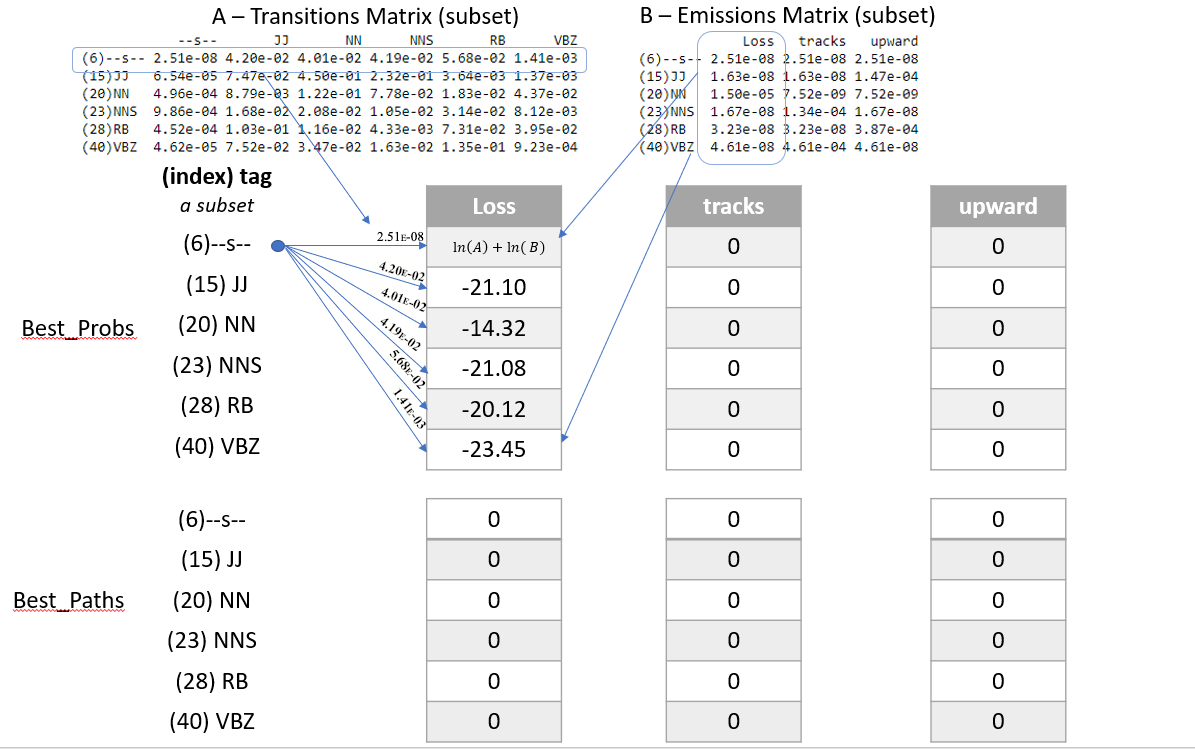

Represent infinity and negative infinity like this:

```CPP
float('inf')
float('-inf')
```

In [25]:
# UNQ_C5 GRADED FUNCTION: initialize
def initialize(states, tag_counts, A, B, corpus, vocab):
    '''
    Input: 
        states: a list of all possible parts-of-speech
        tag_counts: a dictionary mapping each tag to its respective count
        A: Transition Matrix of dimension (num_tags, num_tags)
        B: Emission Matrix of dimension (num_tags, len(vocab))
        corpus: a sequence of words whose POS is to be identified in a list 
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output:
        best_probs: matrix of dimension (num_tags, len(corpus)) of floats
        best_paths: matrix of dimension (num_tags, len(corpus)) of integers
    '''
    # Get the total number of unique POS tags
    num_tags = len(tag_counts)
    
    # Initialize best_probs matrix 
    # POS tags in the rows, number of words in the corpus as the columns
    best_probs = np.zeros((num_tags, len(corpus)))
    
    # Initialize best_paths matrix
    # POS tags in the rows, number of words in the corpus as columns
    best_paths = np.zeros((num_tags, len(corpus)), dtype=int)
    
    # Define the start token
    s_idx = states.index("--s--")
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    
    # Go through each of the POS tags
    for i in range(num_tags): # Replace None in this line with the proper range.
        
        # Handle the special case when the transition from start token to POS tag i is zero
        if A[s_idx, i] == 0: # Replace None in this line with the proper condition. # POS by word
            
            # Initialize best_probs at POS tag 'i', column 0, to negative infinity
            best_probs[i,0] = float("-inf")
        
        # For all other cases when transition from start token to POS tag i is non-zero:
        else:
            
            # Initialize best_probs at POS tag 'i', column 0
            # Check the formula in the instructions above
            best_probs[i,0] = math.log(A[s_idx, i]) + math.log(B[i, vocab[corpus[0]]])
            
    ### END CODE HERE ### 
    return best_probs, best_paths

In [26]:
best_probs, best_paths = initialize(states, tag_counts, A, B, prep, vocab)

In [27]:
# Test the function
print(f"best_probs[0,0]: {best_probs[0,0]:.4f}")
print(f"best_paths[2,3]: {best_paths[2,3]:.4f}")

best_probs[0,0]: -22.6098
best_paths[2,3]: 0.0000


##### Expected Output

```CPP
best_probs[0,0]: -22.6098
best_paths[2,3]: 0.0000
```


In [28]:
# Test your function
w2_unittest.test_initialize(initialize, states, tag_counts, A, B, prep, vocab)

 All tests passed


<a name='3.2'></a>
###  3.2 - Viterbi Forward

In this part of the assignment, you will implement the `viterbi_forward` segment. In other words, you will populate your `best_probs` and `best_paths` matrices.
- Walk forward through the corpus.
- For each word, compute a probability for each possible tag. 
- Unlike the previous algorithm `predict_pos` (the 'warm-up' exercise), this will include the path up to that (word,tag) combination. 

Here is an example with a three-word corpus "Loss tracks upward":
- Note, in this example, only a subset of states (POS tags) are shown in the diagram below, for easier reading. 
- In the diagram below, the first word "Loss" is already initialized. 
- The algorithm will compute a probability for each of the potential tags in the second and future words. 

Compute the probability that the tag of the second word ('tracks') is a verb, 3rd person singular present (VBZ).  
- In the `best_probs` matrix, go to the column of the second word ('tracks'), and row 40 (VBZ), this cell is highlighted in light orange in the diagram below.
- Examine each of the paths from the tags of the first word ('Loss') and choose the most likely path.  
- An example of the calculation for **one** of those paths is the path from ('Loss', NN) to ('tracks', VBZ).
- The log of the probability of the path up to and including the first word 'Loss' having POS tag NN is $-14.32$.  The `best_probs` matrix contains this value -14.32 in the column for 'Loss' and row for 'NN'.
- Find the probability that NN transitions to VBZ.  To find this probability, go to the `A` transition matrix, and go to the row for 'NN' and the column for 'VBZ'.  The value is $4.37e-02$, which is circled in the diagram, so add $-14.32 + log(4.37e-02)$. 
- Find the log of the probability that the tag VBS would 'emit' the word 'tracks'.  To find this, look at the 'B' emission matrix in row 'VBZ' and the column for the word 'tracks'.  The value $4.61e-04$ is circled in the diagram below.  So add $-14.32 + log(4.37e-02) + log(4.61e-04)$.
- The sum of $-14.32 + log(4.37e-02) + log(4.61e-04)$ is $-25.13$. Store $-25.13$ in the `best_probs` matrix at row 'VBZ' and column 'tracks' (as seen in the cell that is highlighted in light orange in the diagram).
- All other paths in best_probs are calculated.  Notice that $-25.13$ is greater than all of the other values in column 'tracks' of matrix `best_probs`, and so the most likely path to 'VBZ' is from 'NN'.  'NN' is in row 20 of the `best_probs` matrix, so $20$ is the most likely path.
- Store the most likely path $20$ in the `best_paths` table.  This is highlighted in light orange in the diagram below.

The formula to compute the probability and path for the $i^{th}$ word in the $corpus$, the prior word $i-1$ in the corpus, current POS tag $j$, and previous POS tag $k$ is:

$\mathrm{prob} = \mathbf{best\_prob}_{k, i-1} + \mathrm{log}(\mathbf{A}_{k, j}) + \mathrm{log}(\mathbf{B}_{j, vocab(corpus_{i})})$

where $corpus_{i}$ is the word in the corpus at index $i$, and $vocab$ is the dictionary that gets the unique integer that represents a given word.

$\mathrm{path} = k$

where $k$ is the integer representing the previous POS tag.


<a name='ex-6'></a>
### Exercise 6 - viterbi_forward

Instructions: Implement the `viterbi_forward` algorithm and store the best_path and best_prob for every possible tag for each word in the matrices `best_probs` and `best_tags` using the pseudo code below.

```
for each word in the corpus

    for each POS tag type that this word may be
    
        for POS tag type that the previous word could be
        
            compute the probability that the previous word had a given POS tag, that the current word has a given POS tag, and that the POS tag would emit this current word.
            
            retain the highest probability computed for the current word
            
            set best_probs to this highest probability
            
            set best_paths to the index 'k', representing the POS tag of the previous word which produced the highest probability 
```

Please use [math.log](https://docs.python.org/3/library/math.html) to compute the natural logarithm.

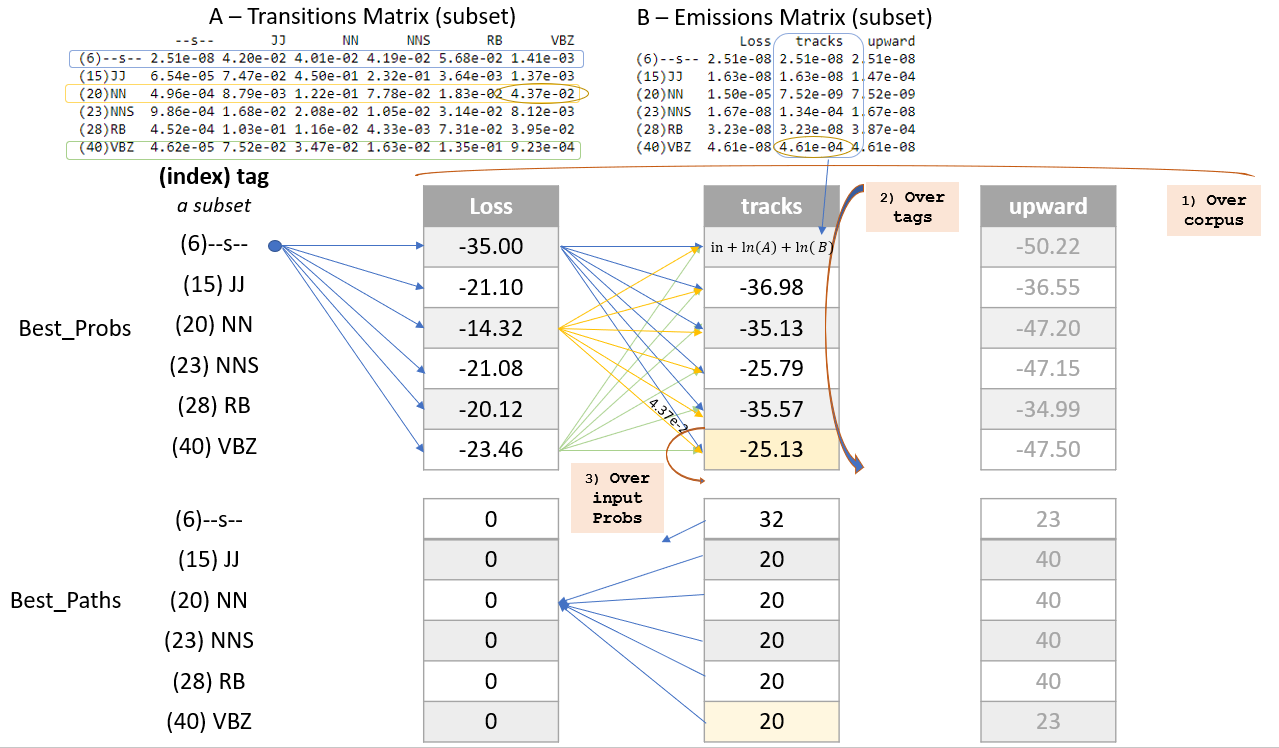

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Remember that when accessing emission matrix B, the column index is the unique integer ID associated with the word.  It can be accessed by using the 'vocab' dictionary, where the key is the word, and the value is the unique integer ID for that word.</li>
</ul>
</p>


In [39]:
# UNQ_C6 GRADED FUNCTION: viterbi_forward
def viterbi_forward(A, B, test_corpus, best_probs, best_paths, vocab, verbose=True):
    '''
    Input: 
        A, B: The transition and emission matrices respectively
        test_corpus: a list containing a preprocessed corpus
        best_probs: an initilized matrix of dimension (num_tags, len(corpus))
        best_paths: an initilized matrix of dimension (num_tags, len(corpus))
        vocab: a dictionary where keys are words in vocabulary and value is an index 
    Output: 
        best_probs: a completed matrix of dimension (num_tags, len(corpus))
        best_paths: a completed matrix of dimension (num_tags, len(corpus))
    '''
    # Get the number of unique POS tags (which is the num of rows in best_probs)
    num_tags = best_probs.shape[0]
    
    # Go through every word in the corpus starting from word 1
    # Recall that word 0 was initialized in `initialize()`
    for i in range(1, len(test_corpus)): 
        
        # Print number of words processed, every 5000 words
        if i % 5000 == 0 and verbose:
            print("Words processed: {:>8}".format(i))
            
        ### START CODE HERE  (Replace instances of 'None' with your code EXCEPT the first 'best_path_i = None')  ###
        # For each unique POS tag that the current word can be
        for j in range(num_tags): # Replace None in this line with the proper range. # for every pos tag
            
            # Initialize best_prob for word i to negative infinity
            best_prob_i = float("-inf")
            
            # Initialize best_path for current word i to None
            best_path_i = None # Do not replace this None

            # For each POS tag that the previous word can be:
            for k in range(num_tags): # Replace None in this line with the proper range.
            
                # Calculate the probability = None
                # best probs of POS tag k, previous word i-1 + 
                # log(prob of transition from POS k to POS j) + 
                # log(prob that emission of POS j is word i)
                prob = best_probs[k, i-1] + math.log(A[k, j]) + math.log(B[j, vocab[test_corpus[i]]])

                # check if this path's probability is greater than
                # the best probability up to and before this point
                if prob > best_prob_i: # Replace None in this line with the proper condition.
                    
                    # Keep track of the best probability
                    best_prob_i = prob
                    
                    # keep track of the POS tag of the previous word
                    # that is part of the best path.  
                    # Save the index (integer) associated with 
                    # that previous word's POS tag
                    best_path_i = k

            # Save the best probability for the 
            # given current word's POS tag
            # and the position of the current word inside the corpus
            best_probs[j,i] = best_prob_i
            
            # Save the unique integer ID of the previous POS tag
            # into best_paths matrix, for the POS tag of the current word
            # and the position of the current word inside the corpus.
            best_paths[j,i] = best_path_i

        ### END CODE HERE ###
    return best_probs, best_paths

Run the `viterbi_forward` function to fill in the `best_probs` and `best_paths` matrices.

**Note** that this will take a few minutes to run.  There are about 30,000 words to process.

In [40]:
# this will take a few minutes to run => processes ~ 30,000 words
best_probs, best_paths = viterbi_forward(A, B, prep, best_probs, best_paths, vocab)

Words processed:     5000
Words processed:    10000
Words processed:    15000
Words processed:    20000
Words processed:    25000
Words processed:    30000


In [41]:
# Test this function 
print(f"best_probs[0,1]: {best_probs[0,1]:.4f}") 
print(f"best_probs[0,4]: {best_probs[0,4]:.4f}") 

best_probs[0,1]: -24.7822
best_probs[0,4]: -49.5601


##### Expected Output

```CPP
best_probs[0,1]: -24.7822
best_probs[0,4]: -49.5601
```

In [42]:
# Test your function: this test may take some time to run
w2_unittest.test_viterbi_forward(viterbi_forward, A, B, prep, vocab)

 All tests passed


<a name='3.3'></a>
### 3.3 - Viterbi Backward

Now you will implement the Viterbi backward algorithm.
- The Viterbi backward algorithm gets the predictions of the POS tags for each word in the corpus using the `best_paths` and the `best_probs` matrices.

The example below shows how to walk backwards through the best_paths matrix to get the POS tags of each word in the corpus. Recall that this example corpus has three words: "Loss tracks upward".

POS tag for 'upward' is `RB`
- Select the the most likely POS tag for the last word in the corpus, 'upward' in the `best_prob` table.
- Look for the row in the column for 'upward' that has the largest probability.
- Notice that in row 28 of `best_probs`, the estimated probability is -34.99, which is larger than the other values in the column.  So the most likely POS tag for 'upward' is `RB` an adverb, at row 28 of `best_prob`. 
- The variable `z` is an array that stores the unique integer ID of the predicted POS tags for each word in the corpus.  In array z, at position 2, store the value 28 to indicate that the word 'upward' (at index 2 in the corpus), most likely has the POS tag associated with unique ID 28 (which is `RB`).
- The variable `pred` contains the POS tags in string form.  So `pred` at index 2 stores the string `RB`.


POS tag for 'tracks' is `VBZ`
- The next step is to go backward one word in the corpus ('tracks').  Since the most likely POS tag for 'upward' is `RB`, which is uniquely identified by integer ID 28, go to the `best_paths` matrix in column 2, row 28.  The value stored in `best_paths`, column 2, row 28 indicates the unique ID of the POS tag of the previous word.  In this case, the value stored here is 40, which is the unique ID for POS tag `VBZ` (verb, 3rd person singular present).
- So the previous word at index 1 of the corpus ('tracks'), most likely has the POS tag with unique ID 40, which is `VBZ`.
- In array `z`, store the value 40 at position 1, and for array `pred`, store the string `VBZ` to indicate that the word 'tracks' most likely has POS tag `VBZ`.

POS tag for 'Loss' is `NN`
- In `best_paths` at column 1, the unique ID stored at row 40 is 20.  20 is the unique ID for POS tag `NN`.
- In array `z` at position 0, store 20.  In array `pred` at position 0, store `NN`.

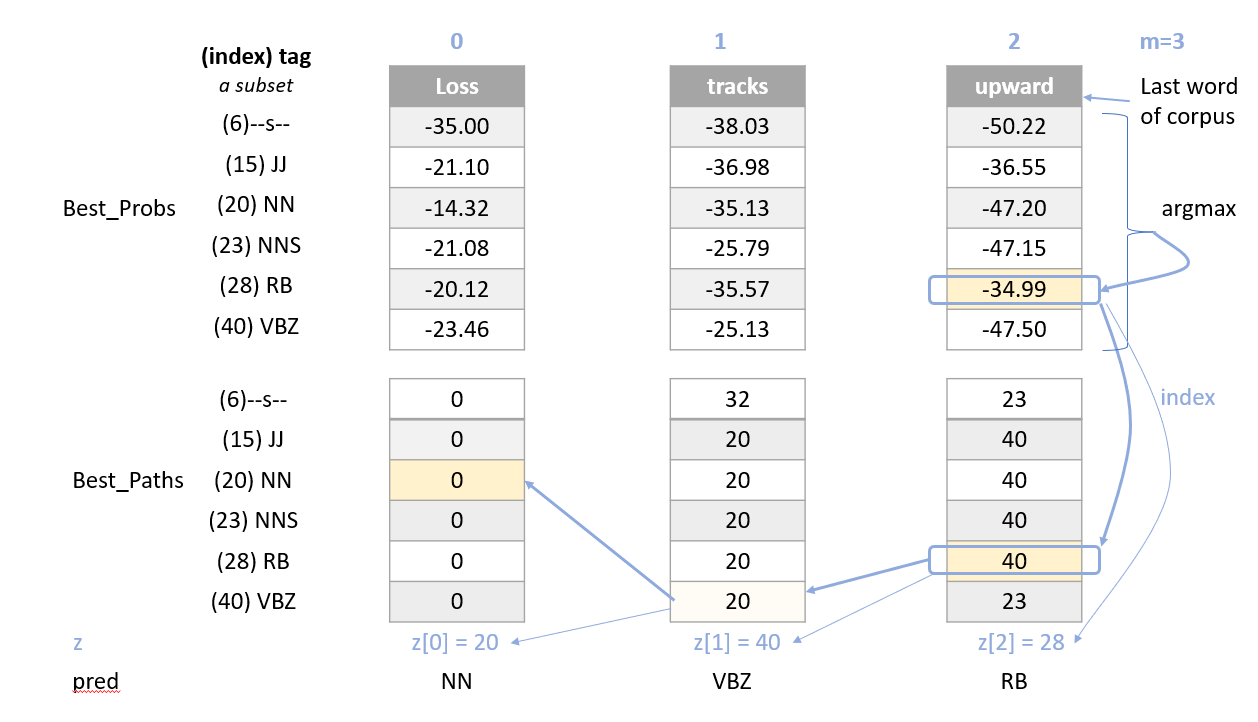

<a name='ex-7'></a>
### Exercise 7 - viterbi_backward
Implement the `viterbi_backward` algorithm, which returns a list of predicted POS tags for each word in the corpus.

- Note that the numbering of the index positions starts at 0 and not 1. 
- `m` is the number of words in the corpus.  
    - So the indexing into the corpus goes from `0` to `m - 1`.
    - Also, the columns in `best_probs` and `best_paths` are indexed from `0` to `m - 1`


**In Step 1:**       
Loop through all the rows (POS tags) in the last entry of `best_probs` and find the row (POS tag) with the maximum value.
Convert the unique integer ID to a tag (a string representation) using the list `states`.  

Referring to the three-word corpus described above:
- `z[2] = 28`: For the word 'upward' at position 2 in the corpus, the POS tag ID is 28.  Store 28 in `z` at position 2.
- `states[28]` is 'RB': The POS tag ID 28 refers to the POS tag 'RB'.
- `pred[2] = 'RB'`: In array `pred`, store the POS tag for the word 'upward'.

**In Step 2:**  
- Starting at the last column of best_paths, use `best_probs` to find the most likely POS tag for the last word in the corpus.
- Then use `best_paths` to find the most likely POS tag for the previous word. 
- Update the POS tag for each word in `z` and in `preds`.

Referring to the three-word example from above, read best_paths at column 2 and fill in z at position 1.  
`z[1] = best_paths[z[2],2]`  

The small test following the routine prints the last few words of the corpus and their states to aid in debug.

In [45]:
# UNQ_C7 GRADED FUNCTION: viterbi_backward
def viterbi_backward(best_probs, best_paths, corpus, states):
    '''
    This function returns the best path.
    
    '''
    # Get the number of words in the corpus
    # which is also the number of columns in best_probs, best_paths
    m = best_paths.shape[1] 
    
    # Initialize array z, same length as the corpus
    z = [None] * m
    
    # Get the number of unique POS tags
    num_tags = best_probs.shape[0]
    
    # Initialize the best probability for the last word
    best_prob_for_last_word = float('-inf')
    
    # Initialize pred array, same length as corpus
    pred = [None] * m
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    ## Step 1 ##
    
    # Go through each POS tag for the last word (last column of best_probs)
    # in order to find the row (POS tag integer ID) 
    # with highest probability for the last word
    for k in range(num_tags): # Replace None in this line with the proper range.

        # If the probability of POS tag at row k 
        # is better than the previously best probability for the last word:
        if best_probs[k, m-1] > best_prob_for_last_word: # Replace None in this line with the proper condition.
            
            # Store the new best probability for the last word
            best_prob_for_last_word = best_probs[k, m-1]

            # Store the unique integer ID of the POS tag
            # which is also the row number in best_probs
            z[m - 1] = k
            
    # Convert the last word's predicted POS tag
    # from its unique integer ID into the string representation
    # using the 'states' list
    # store this in the 'pred' array for the last word
    pred[m - 1] = states[z[m - 1]]
    
    ## Step 2 ##
    # Find the best POS tags by walking backward through the best_paths
    # From the last word in the corpus to the 0th word in the corpus
    for i in range(m-1, 0, -1): # Replace None in this line with the proper range.
        # Retrieve the unique integer ID of
        # the POS tag for the word at position 'i' in the corpus
        pos_tag_for_word_i = states[z[i]]
        
        # In best_paths, go to the row representing the POS tag of word i
        # and the column representing the word's position in the corpus
        # to retrieve the predicted POS for the word at position i-1 in the corpus
        z[i - 1] = best_paths[z[i], i]
        
        # Get the previous word's POS tag in string form
        # Use the 'states' list, 
        # where the key is the unique integer ID of the POS tag,
        # and the value is the string representation of that POS tag
        pred[i - 1] = states[z[i - 1]]
        
     ### END CODE HERE ###
    return pred

In [46]:
# Run and test your function
pred = viterbi_backward(best_probs, best_paths, prep, states)
m=len(pred)
print('The prediction for pred[-7:m-1] is: \n', prep[-7:m-1], "\n", pred[-7:m-1], "\n")
print('The prediction for pred[0:8] is: \n', pred[0:7], "\n", prep[0:7])

The prediction for pred[-7:m-1] is: 
 ['see', 'them', 'here', 'with', 'us', '.'] 
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.'] 

The prediction for pred[0:8] is: 
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN'] 
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken']


**Expected Output:**   

```CPP
The prediction for pred[-7:m-1] is:  
 ['see', 'them', 'here', 'with', 'us', '.']  
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.']   
The prediction for pred[0:8] is:    
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN']   
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken'] 
```

Now you just have to compare the predicted labels to the true labels to evaluate your model on the accuracy metric!

In [47]:
# Test your function
w2_unittest.test_viterbi_backward(viterbi_backward, prep, states)

 All tests passed


<a name='4'></a>
## 4 - Predicting on a Dataset

Compute the accuracy of your prediction by comparing it with the true `y` labels. 
- `pred` is a list of predicted POS tags corresponding to the words of the `test_corpus`. 

In [48]:
print('The third word is:', prep[3])
print('Your prediction is:', pred[3])
print('Your corresponding label y is: ', y[3])

The third word is: temperature
Your prediction is: NN
Your corresponding label y is:  temperature	NN



<a name='ex-8'></a>
### Exercise 8 - compute_accuracy

Implement a function to compute the accuracy of the viterbi algorithm's POS tag predictions.
- To split y into the word and its tag you can use `y.split()`. 

In [49]:
# UNQ_C8 GRADED FUNCTION: compute_accuracy
def compute_accuracy(pred, y):
    '''
    Input: 
        pred: a list of the predicted parts-of-speech 
        y: a list of lines where each word is separated by a '\t' (i.e. word \t tag)
    Output: 
        
    '''
    num_correct = 0
    total = 0
    
    # Zip together the prediction and the labels
    for prediction, y in zip(pred, y):
        ### START CODE HERE (Replace instances of 'None' with your code) ###
        # Split the label into the word and the POS tag
        word_tag_tuple = y.split()
        
        # Check that there is actually a word and a tag
        # no more and no less than 2 items
        if len(word_tag_tuple) != 2: # Replace None in this line with the proper condition.
            continue

        # store the word and tag separately
        word, tag = word_tag_tuple
        
        # Check if the POS tag label matches the prediction
        if prediction == tag: # Replace None in this line with the proper condition.
            
            # count the number of times that the prediction
            # and label match
            num_correct += 1
            
        # keep track of the total number of examples (that have valid labels)
        total += 1

        ### END CODE HERE ###
    return num_correct/total

In [50]:
print(f"Accuracy of the Viterbi algorithm is {compute_accuracy(pred, y):.4f}")

Accuracy of the Viterbi algorithm is 0.9531


##### Expected Output

```CPP
Accuracy of the Viterbi algorithm is 0.9531
```

Congratulations you were able to classify the parts-of-speech with 95% accuracy. 

In [51]:
# Test your function
w2_unittest.test_compute_accuracy(compute_accuracy, pred, y)

 All tests passed


#### Key Points and overview

In this assignment you learned about parts-of-speech tagging. 
- In this assignment, you predicted POS tags by walking forward through a corpus and knowing the previous word.
- There are other implementations that use bidirectional POS tagging.
- Bidirectional POS tagging requires knowing the previous word and the next word in the corpus when predicting the current word's POS tag.
- Bidirectional POS tagging would tell you more about the POS instead of just knowing the previous word. 
- Since you have learned to implement the unidirectional approach, you have the foundation to implement other POS taggers used in industry.

### References

- ["Speech and Language Processing", Dan Jurafsky and James H. Martin](https://web.stanford.edu/~jurafsky/slp3/)
- We would like to thank Melanie Tosik for her help and inspiration